## **Lifelines classifier:**
> Floris Menninga \
> Datum: 3-03-2025 \
> Versie: 1



In [232]:
# !pip install pandas
# !pip install matplotlib
# !pip install numpy
# !pip install seaborn
# !pip install scipy
# !pip install scikit-learn

# Oversampling met SMOTE:
from imblearn.over_sampling import SMOTE

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split

## De gebruikte dataset:

Voor dit model zal gebruik gemaakt worden van de lifelines dataset. 
Dit is een bevolkingsonderzoek dat in noord Nederland (Groningen, Friesland en Drenthe) gehouden wordt. <br>
<br>
Naast de resultaten van de vragenlijst met datapunten van ~16000 mensen hebben ze ook een verzameling lichaamsmaterialen, hier zal natuurlijk geen gebruik van gemaakt worden voor dit model. <br>

De gebruikte dataset heeft 84 kolommen die allerlei eigenschappen van de deelnemers bevatten zoals: leeftijd, gewicht, lengte maar ook meningen en informatie over de geestelijke gezondheid (depressie etc.)

Deze Lifelines data is geanonimiseerd. Dit is gedaan om de privacy van de deelnemes te waarborgen. 
Volgens hun website zijn alle relaties tussen variablelen wel geconserveerd en is het gemiddelde etc. voor alle kolommen nog wel het zelfde. 


(bron: https://www.lifelines-biobank.com/synthetic-data-a-new-step-forward-in-data-availability-at-lifelines-in-collaboration-with-syntho)


In [233]:
lifelines_df = pd.read_csv("/home/floris/Documenten/git_repo/Lifelines_Classifier/data/Lifelines_Public_Health_dataset_2024.csv")
lifelines_df.index += 1

lifelines_df.head()

,GENDER,BIRTHYEAR,AGE_T1,AGE_T2,AGE_T3,ZIP_CODE,BMI_T1,WEIGHT_T1,HIP_T1,HEIGHT_T1,...,NSES_YEAR,NSES,NEIGHBOURHOOD1_T2,NEIGHBOURHOOD2_T2,NEIGHBOURHOOD3_T2,NEIGHBOURHOOD4_T2,NEIGHBOURHOOD5_T2,NEIGHBOURHOOD6_T2,MENTAL_DISORDER_T1,MENTAL_DISORDER_T2
1,2,1960,52,55,59,9903,21.9,70.0,91.0,178.5,...,2010,-0.148238,8.0,1.0,3.0,5.0,3.0,4.0,0.0,0.0
2,2,1964,48,51,57,8411,20.9,62.0,93.0,172.5,...,2010,0.357413,10.0,1.0,1.0,1.0,5.0,5.0,0.0,0.0
3,2,1951,58,62,68,9101,24.6,71.0,104.0,170.0,...,2010,-1.730366,9.0,1.0,2.0,2.0,3.0,4.0,0.0,0.0
4,1,1958,54,57,61,9761,25.0,70.5,95.0,169.5,...,2010,0.106612,8.0,2.0,1.0,1.0,5.0,5.0,0.0,0.0
5,2,1963,45,50,57,9201,24.0,61.0,95.0,159.8,...,2006,-1.004381,9.0,4.0,1.0,1.0,5.0,5.0,0.0,0.0


De kolomen die gebruikt gaan worden voor dit model hebben "score" als eenheid. 

In [235]:
codebook = {
    "attribute": lifelines_df.columns.tolist(), # Gebruik de kolom namen van het df voor de namen hier. 
    "unit": ["geslacht", "", "Jaar", "Jaar", "Jaar", "kg/m2", "kg", "cm", "cm", "cm", "kg/m2", "kg", "cm", "cm", "cm", "kg", "cm", "cm", "cm", "", "", "", "", "", "", "", "mmHg", "mmHg", "BPM", "BPM", "", "", "mmHg", "mmHg", "", "mmol/L", "mmol/L", "mmol/L", "mmol/L", "", "", "", "", "", "", "", "", "gram/day", "kcal/dag", "minuten", "", "minuten", "", "%","", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "Jaar ", "", "score", "score","score", "score", "score","score", "score", "score",],
    "dtype": lifelines_df.dtypes.tolist(), # Datatypes hier.
}

pd.DataFrame(codebook).set_index("attribute")

,unit,dtype
attribute,,
GENDER,geslacht,int64
BIRTHYEAR,,int64
AGE_T1,Jaar,int64
AGE_T2,Jaar,int64
AGE_T3,Jaar,int64
...,...,...
NEIGHBOURHOOD4_T2,score,float64
NEIGHBOURHOOD5_T2,score,float64
NEIGHBOURHOOD6_T2,score,float64


De "unit" kolommen zijn met de hand ingevuld. \
Optimalisatie: float64 en int64 vervangen door int8, de nummers blijven er toch ver onder. (To-do)

In [4]:
pd.DataFrame({
    "isna": lifelines_df.isna().sum()
})


,isna
GENDER,0
BIRTHYEAR,0
AGE_T1,0
AGE_T2,0
AGE_T3,0
...,...
NEIGHBOURHOOD4_T2,4886
NEIGHBOURHOOD5_T2,4887
NEIGHBOURHOOD6_T2,4884
MENTAL_DISORDER_T1,376


Veel NA's, deze worden er later uitgehaald met imputatie.


/tmp/ipykernel_890170/2388124128.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  axs = sns.histplot(lifelines_df["GENDER"], palette="viridis")


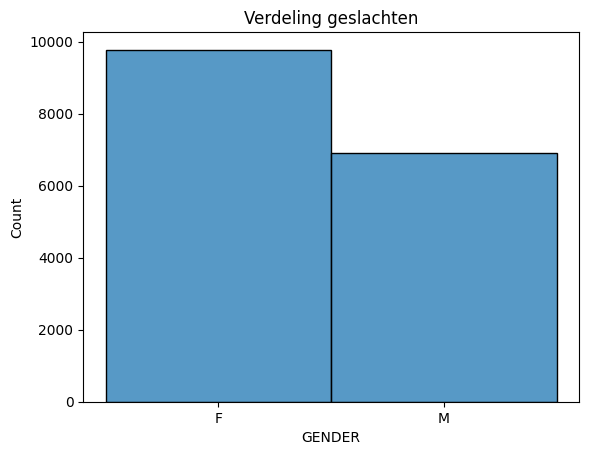

In [236]:
lifelines_df["GENDER"] = lifelines_df["GENDER"].map({2: "F", 1: "M"})

axs = sns.histplot(lifelines_df["GENDER"], palette="viridis")
axs.set_title("Verdeling geslachten");

lifelines_df["GENDER"] = lifelines_df["GENDER"].map({"F": 2, "M": 1})

De "1" en "2" zijn vervangen door F voor vrouw en M voor man. 



Ongelijke verdeling van Man/Vrouw datapunten. Meer vrouwen dan mannen. 


In [237]:
lifelines_df.describe()

,GENDER,BIRTHYEAR,AGE_T1,AGE_T2,AGE_T3,ZIP_CODE,BMI_T1,WEIGHT_T1,HIP_T1,HEIGHT_T1,...,NSES_YEAR,NSES,NEIGHBOURHOOD1_T2,NEIGHBOURHOOD2_T2,NEIGHBOURHOOD3_T2,NEIGHBOURHOOD4_T2,NEIGHBOURHOOD5_T2,NEIGHBOURHOOD6_T2,MENTAL_DISORDER_T1,MENTAL_DISORDER_T2
count,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,...,16696.000000,16200.000000,11747.000000,11806.000000,11812.000000,11810.000000,11809.000000,11812.000000,16320.000000,13472.000000
mean,1.585709,1963.883265,46.621766,50.386859,56.395604,9088.022221,25.948491,79.580642,99.176186,174.920394,...,2009.363201,-0.576549,8.218609,1.942317,1.451490,1.755631,3.689813,4.075855,0.079534,0.085065
std,0.492614,11.159835,11.179438,11.128222,11.160991,703.594702,4.110023,14.718271,9.177001,9.352034,...,1.463493,1.079084,1.460666,0.821344,0.680361,1.038783,1.016746,0.810044,0.320736,0.333972
min,1.000000,1927.000000,18.000000,20.000000,25.000000,1015.000000,15.400000,42.000000,62.000000,137.000000,...,2006.000000,-7.121883,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1957.000000,40.000000,43.000000,49.000000,8496.500000,23.200000,69.000000,93.000000,168.000000,...,2010.000000,-1.194383,8.000000,1.000000,1.000000,1.000000,3.000000,4.000000,0.000000,0.000000
50%,2.000000,1964.000000,47.000000,51.000000,57.000000,9281.000000,25.400000,78.000000,98.000000,174.000000,...,2010.000000,-0.580492,8.000000,2.000000,1.000000,1.000000,4.000000,4.000000,0.000000,0.000000
75%,2.000000,1971.000000,54.000000,57.000000,64.000000,9654.000000,28.000000,89.000000,104.000000,181.500000,...,2010.000000,0.183076,9.000000,2.000000,2.000000,2.000000,4.000000,5.000000,0.000000,0.000000
max,2.000000,1995.000000,84.000000,88.000000,95.000000,9998.000000,53.800000,158.000000,185.000000,207.000000,...,2010.000000,2.933054,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000


In [238]:
def by_unit(*units):
    # Retourneert een lijst van attributen die gevraagde eenheden hebben
    return [attribute for attribute, unit in zip(codebook["attribute"], codebook["unit"]) if unit in units]

Text(0.5, 1.0, 'Afmeting-distributies [cm]')

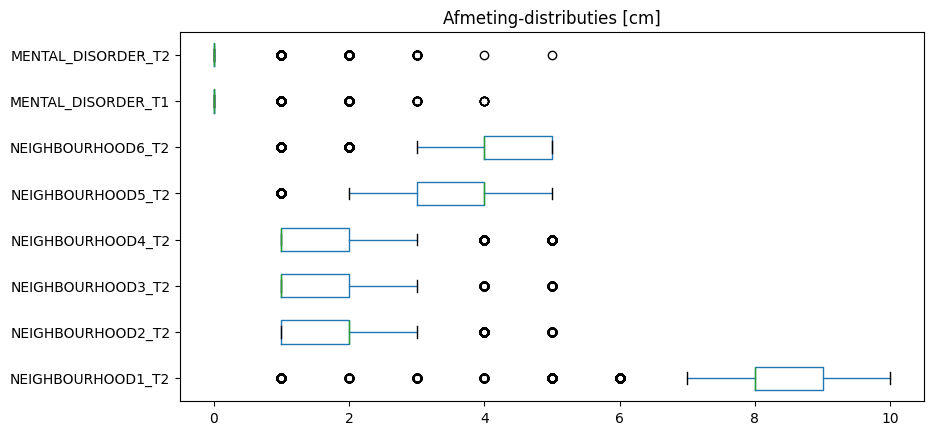

In [240]:
axs = lifelines_df[by_unit("score")].boxplot(grid=False, vert=False, figsize=(9.6, 4.8))
axs.set_title("Afmeting-distributies [cm]")

Er zijn een groot aantal uitschieters.

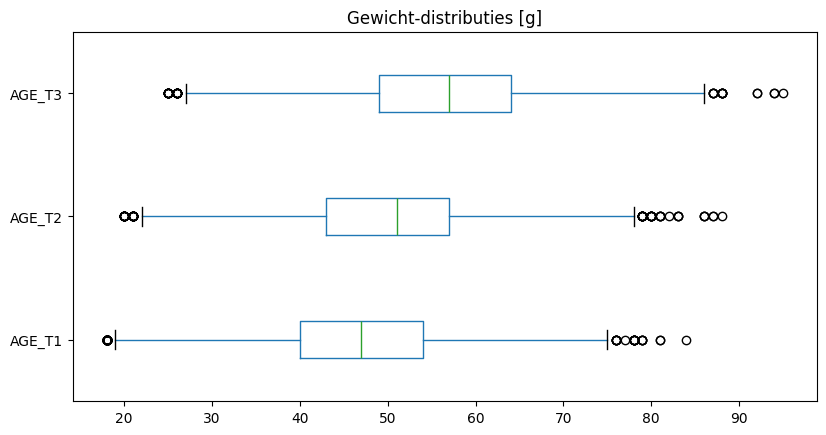

In [9]:
axs = lifelines_df[by_unit("Jaar")].boxplot(grid=False, vert=False, figsize=(9.6, 4.8))
axs.set_title("Gewicht-distributies [g]");

Tussen de verschillende meetpunten (T1 t/m T3) liggen de leeftijden steeds wat hoger, zoals verwachts. 

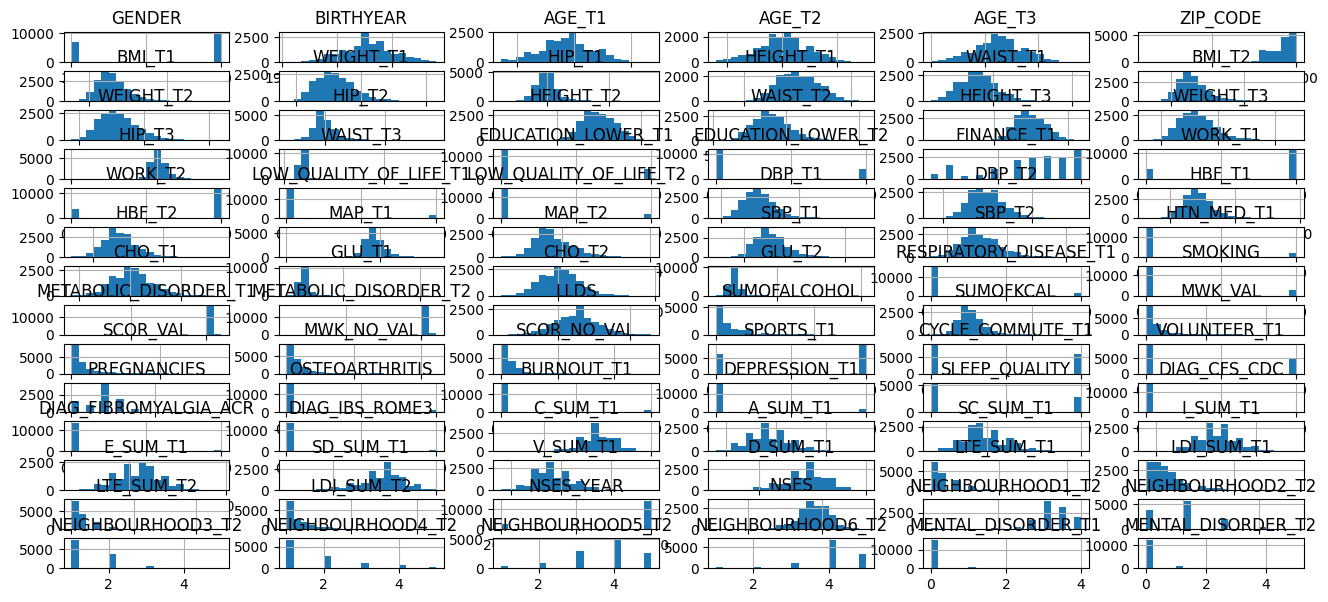

In [10]:
lifelines_df.hist(bins=20, layout=(20, 6), figsize=(16.0, 10));

Het bovenstaande histogram weergeeft alle features.<br> Veel continue features zijn normaal verdeeld maar de categorische zoals levenskwaliteits beoordelingen niet. 

<br>
De versie hieronder laat enkel de features zien die gebruikt gaan worden.
Veel van de kolomen lijken een Poisson verdeling te hebben.


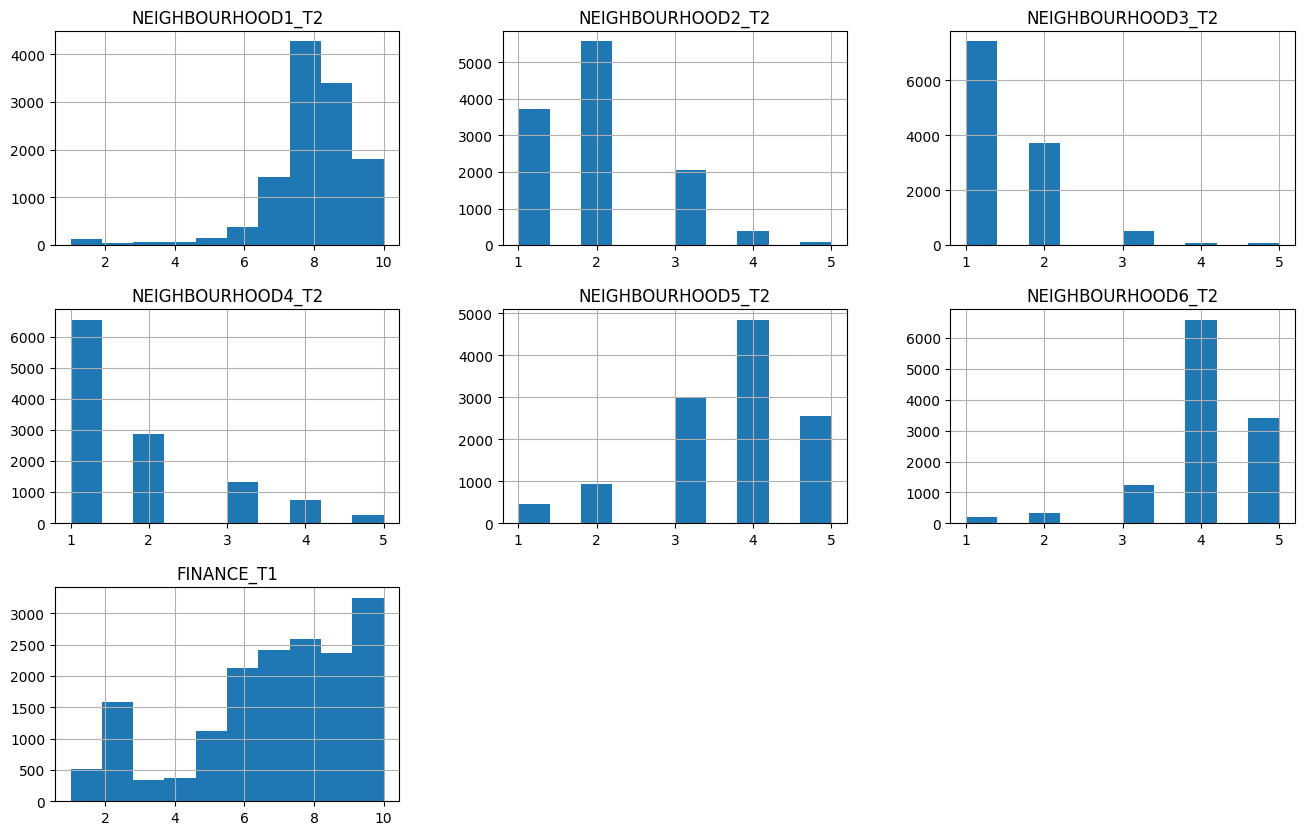

In [11]:

lifelines_df[["NEIGHBOURHOOD1_T2", "NEIGHBOURHOOD2_T2", "NEIGHBOURHOOD3_T2", "NEIGHBOURHOOD4_T2", "NEIGHBOURHOOD5_T2","NEIGHBOURHOOD6_T2", "FINANCE_T1"]].hist(figsize=(16.0, 10));

Zoals zichtbaar is de data in geen van de gevallen normaal verdeeld. Aangezien het ordinale categorische features zijn is het geen goed idee om een log/wortel transformatie er op uit te voeren. 
<br>
Het kan wel worden toegepast op de onderstaande kolomen:

In [12]:
logdata = np.sqrt(lifelines_df[["NEIGHBOURHOOD1_T2", "NEIGHBOURHOOD2_T2", "NEIGHBOURHOOD3_T2", "NEIGHBOURHOOD4_T2", "NEIGHBOURHOOD5_T2","NEIGHBOURHOOD6_T2", "FINANCE_T1"]])
lifelines_df_transformed_test = pd.DataFrame()

for attribute in ["NEIGHBOURHOOD1_T2", "NEIGHBOURHOOD2_T2", "NEIGHBOURHOOD3_T2", "NEIGHBOURHOOD4_T2", "NEIGHBOURHOOD5_T2","NEIGHBOURHOOD6_T2", "FINANCE_T1"]:
    index = codebook["attribute"].index(attribute)
    codebook["unit"][index] = "-"
    lifelines_df_transformed_test.rename(columns={attribute: attribute}, inplace=True)
    lifelines_df_transformed_test[attribute] = logdata[attribute]

pd.DataFrame(codebook).set_index("attribute")

,unit,dtype
attribute,,
GENDER,geslacht,int64
BIRTHYEAR,,int64
AGE_T1,Jaar,int64
AGE_T2,Jaar,int64
AGE_T3,Jaar,int64
...,...,...
NEIGHBOURHOOD4_T2,-,float64
NEIGHBOURHOOD5_T2,-,float64
NEIGHBOURHOOD6_T2,-,float64


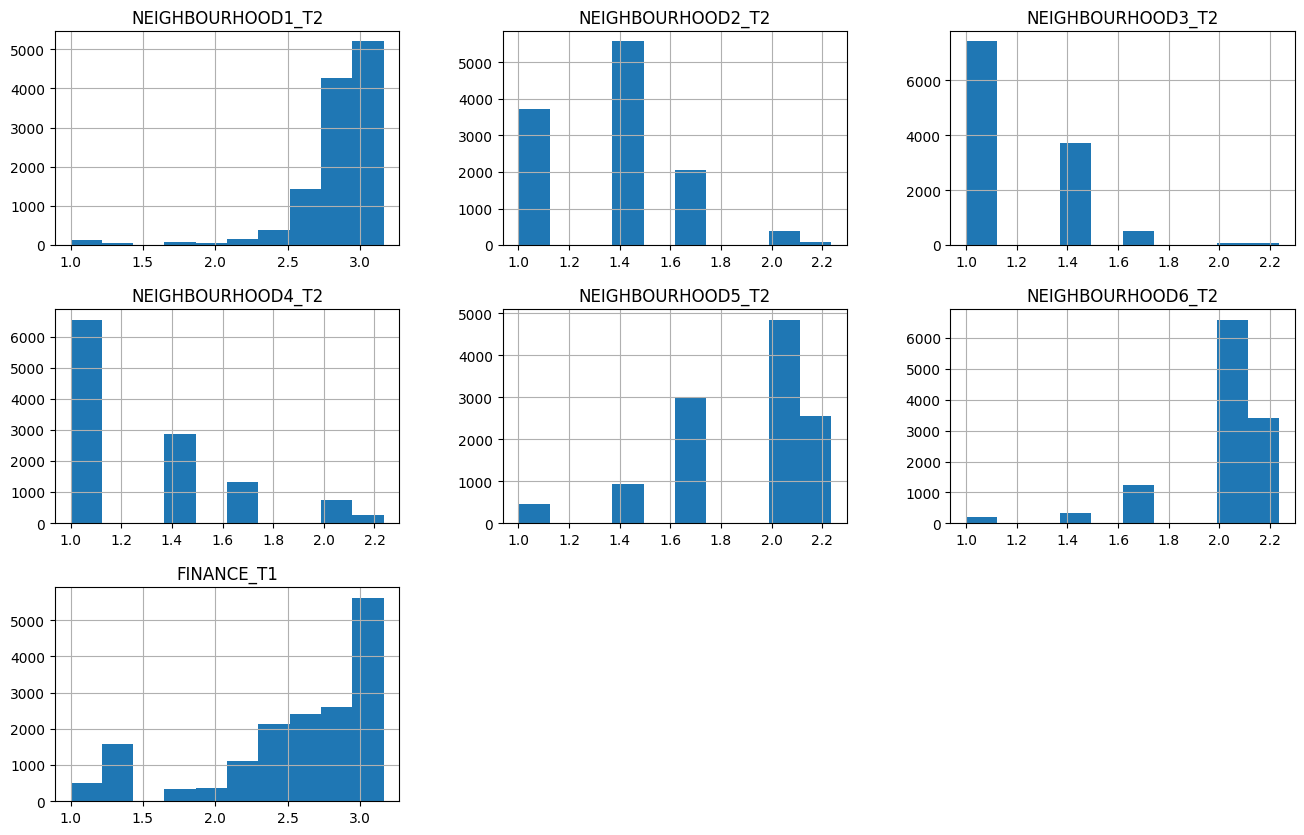

In [13]:
lifelines_df_transformed_test[["NEIGHBOURHOOD1_T2", "NEIGHBOURHOOD2_T2", "NEIGHBOURHOOD3_T2", "NEIGHBOURHOOD4_T2", "NEIGHBOURHOOD5_T2","NEIGHBOURHOOD6_T2", "FINANCE_T1"]].hist(figsize=(16.0, 10));

De bovenstaande grafiek weergeeft de negatieve invloed van een wortel transformatie op ordinale catagorische data. 
Deze getransformeerde data wordt verworpen en de niet getransformeerde versie wordt gebruikt voor de vervolgestappen. <br>
Als ik de continue features zou gebruiken zou een logaritmische transformatie geschikt zijn voor data zoals leeftijd, gewicht en lengte al zijn deze van nature al normaal verdeeld.




Exploratieve data analyze: Bivariaat 

In [ ]:
grouped = lifelines_df[["GENDER", "HEIGHT_T1"]].groupby("GENDER")


for label1, group1 in grouped:
    for label2, group2 in grouped:
        if label1 < label2:
            t, p = stats.ttest_ind(group1["GENDER"], group2["HEIGHT_T1"]) 
            print(f"{label1} vs. {label2}:\t{p = :8.1e}")

1 vs. 2:	p =  0.0e+00


/home/floris/Documenten/git_repo/Lifelines_Classifier/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Verschil tussen de twee geslachten zijn duidelijk te zien wanneer deze met elkaar vergeleken worden. 

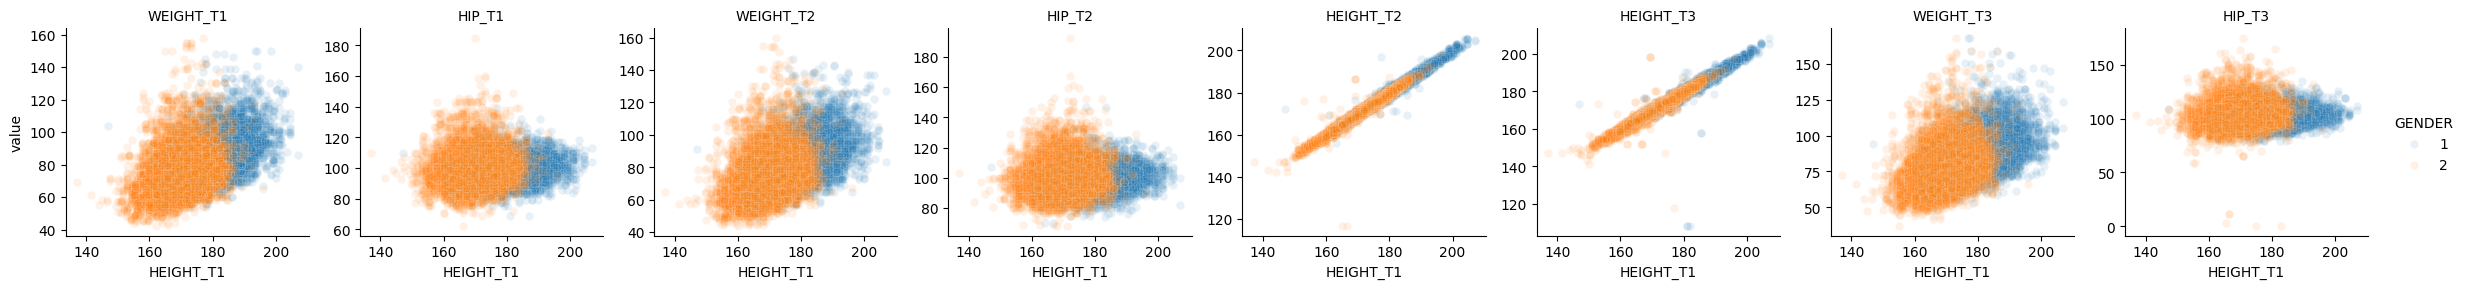

In [36]:
subdata = pd.melt(lifelines_df, id_vars=["AGE_T1", "HEIGHT_T1", "GENDER"], value_vars=by_unit("cm"))
g = sns.FacetGrid(subdata, col="variable", sharey=False, hue="GENDER")
g.map_dataframe(sns.scatterplot, x="HEIGHT_T1", y="value", alpha=0.1).set_titles(col_template="{col_name}").add_legend();

Text(0.5, 1.0, 'aa')

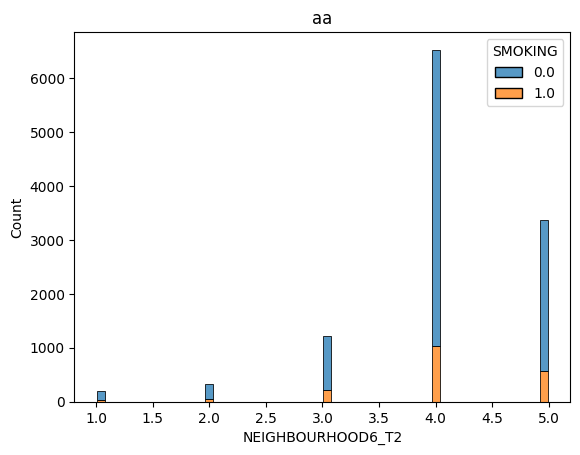

In [90]:



#lifelines_df[["NEIGHBOURHOOD3_T2", "NEIGHBOURHOOD2_T2"]].hist(bins=20);

axs = sns.histplot(lifelines_df, x="NEIGHBOURHOOD6_T2", hue="SMOKING", multiple="stack", shrink=0.8)
axs.set_title("aa")



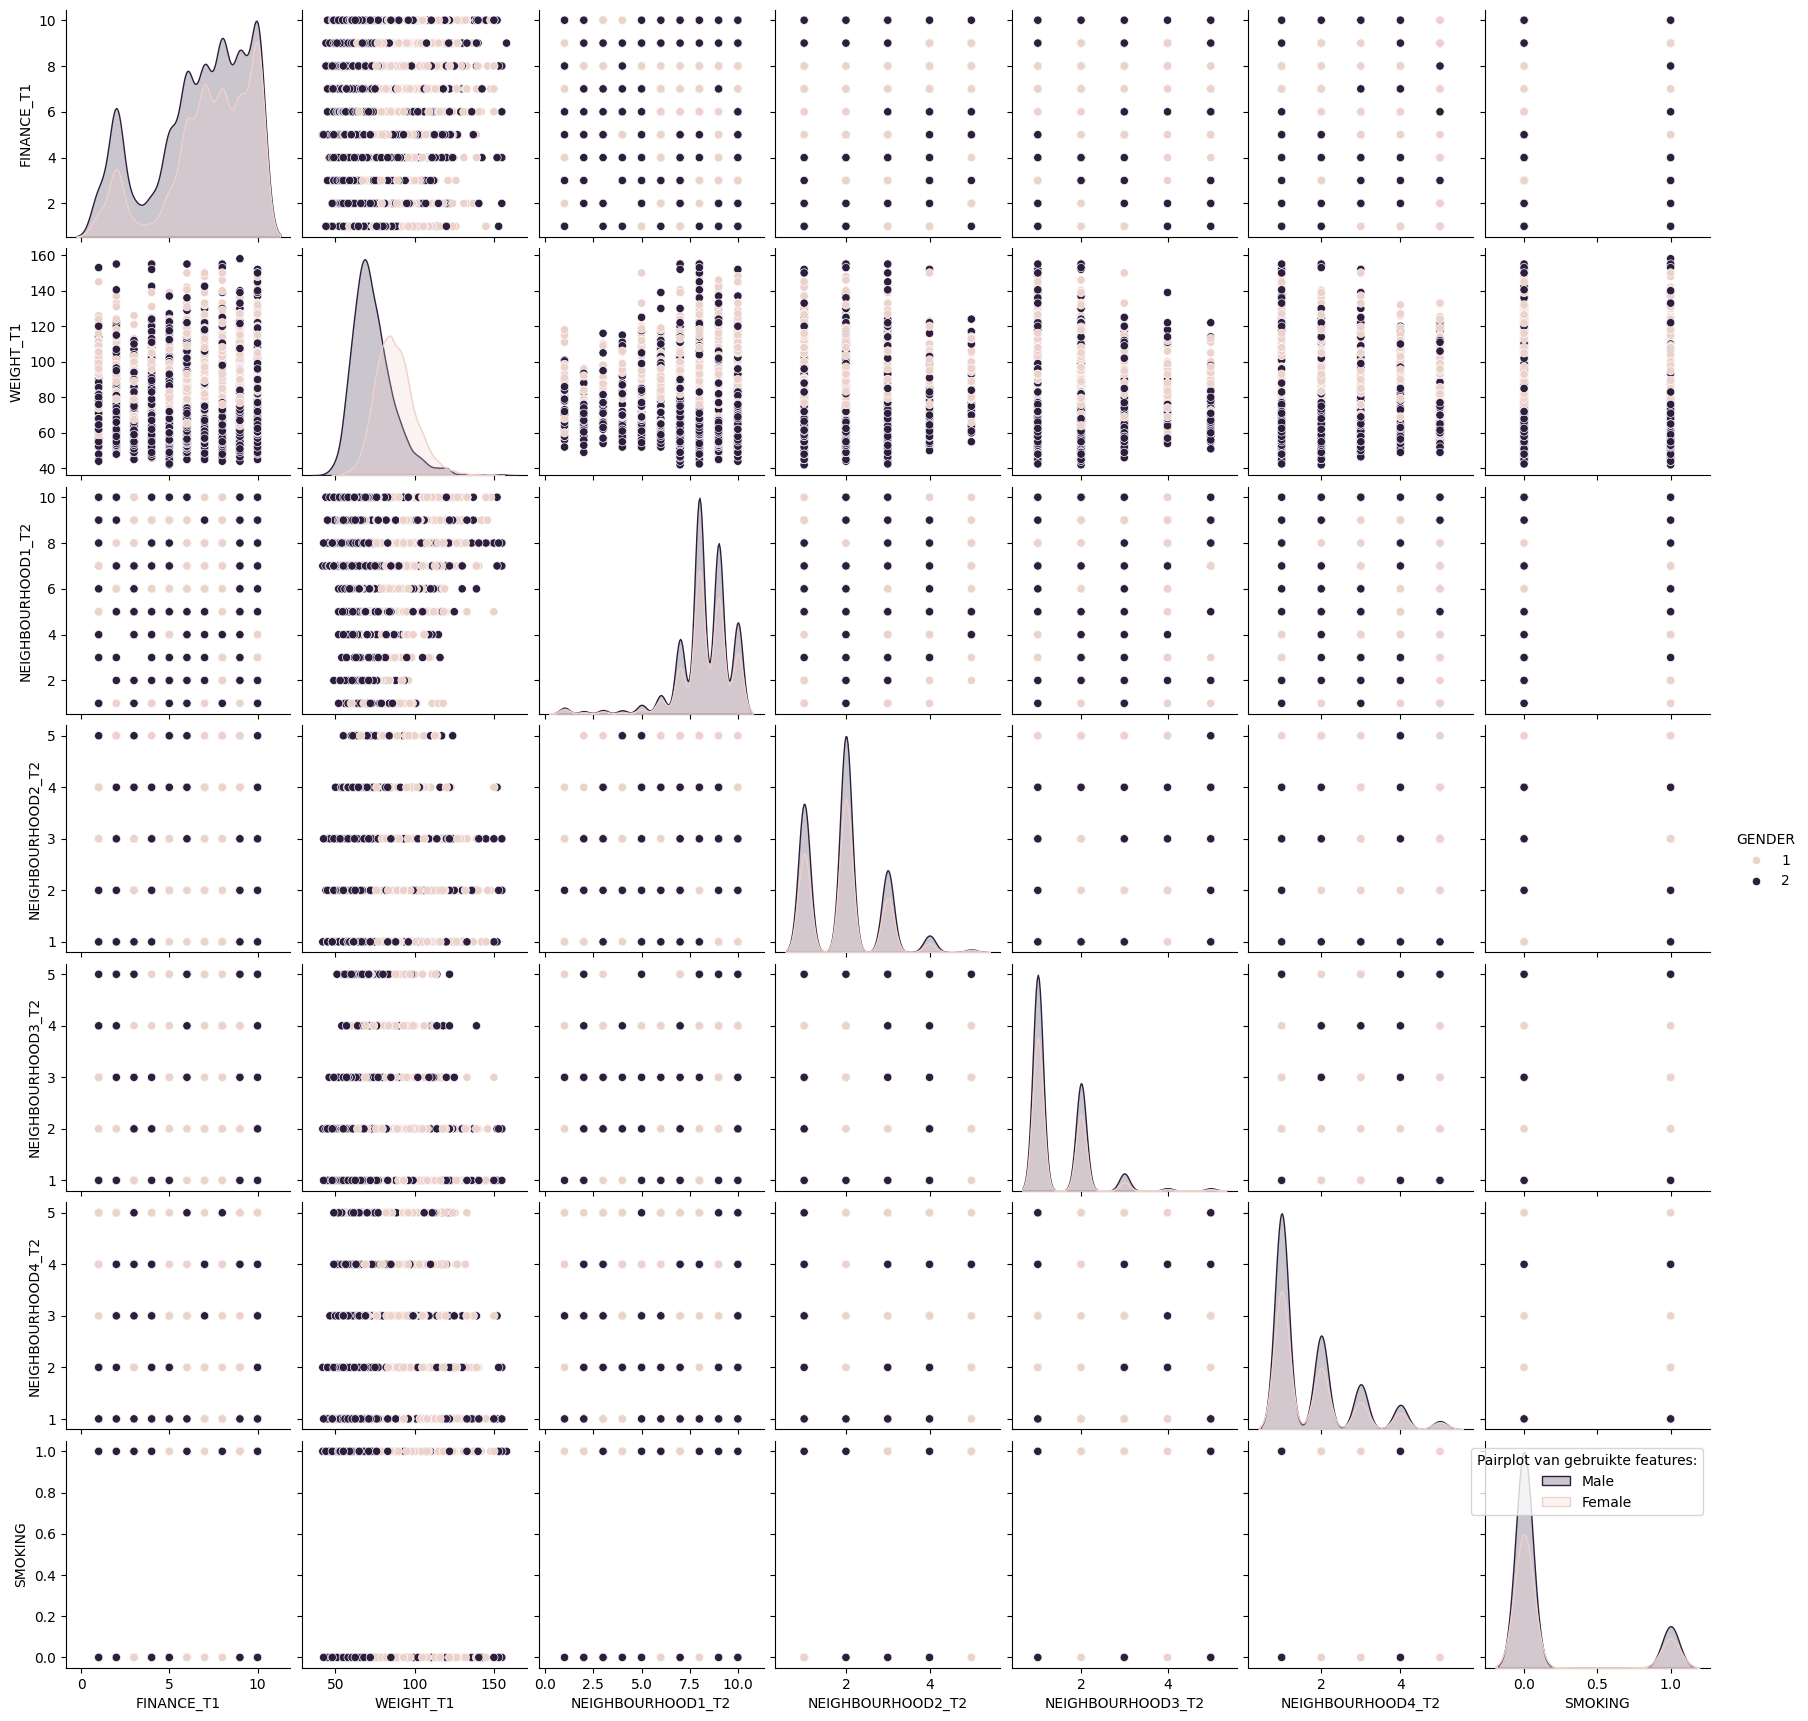

In [106]:
sns.pairplot(pd.DataFrame(lifelines_df[["FINANCE_T1","WEIGHT_T1","NEIGHBOURHOOD1_T2","NEIGHBOURHOOD2_T2","NEIGHBOURHOOD3_T2","NEIGHBOURHOOD4_T2", "GENDER","SMOKING"]]), hue="GENDER")

plt.legend(title='Pairplot van gebruikte features:', loc='best', labels=['Male', 'Female'])
plt.show()

<Axes: xlabel='GENDER', ylabel='count'>

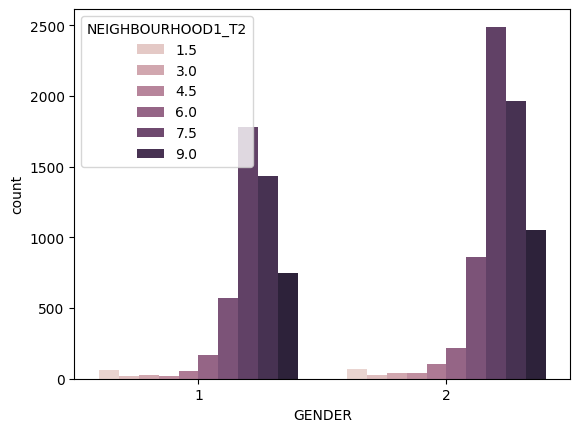

In [87]:
sns.countplot(data=lifelines_df, x="GENDER", hue="NEIGHBOURHOOD1_T2")

In [16]:
lifelines_df[by_unit("","kg", "cm")]

,BIRTHYEAR,BMI_T1,WEIGHT_T1,HIP_T1,HEIGHT_T1,BMI_T2,WEIGHT_T2,HIP_T2,HEIGHT_T2,WAIST_T2,...,I_SUM_T1,E_SUM_T1,SD_SUM_T1,V_SUM_T1,D_SUM_T1,LTE_SUM_T1,LDI_SUM_T1,LTE_SUM_T2,LDI_SUM_T2,NSES
1,1960,21.9,70.0,91.0,178.5,21.9,70.0,97.0,177.0,80.0,...,29.0,19.0,32.0,25.0,30.0,2.0,8.0,0.0,4.0,-0.148238
2,1964,20.9,62.0,93.0,172.5,20.6,60.0,92.0,172.0,75.0,...,31.0,22.0,24.0,22.0,18.0,0.0,4.0,3.0,4.0,0.357413
3,1951,24.6,71.0,104.0,170.0,25.6,74.0,104.0,168.0,95.0,...,25.0,20.0,31.0,16.0,29.0,1.0,0.0,0.0,1.0,-1.730366
4,1958,25.0,70.5,95.0,169.5,25.2,72.0,98.0,168.0,91.0,...,19.0,23.0,31.0,21.0,35.0,0.0,0.0,1.0,0.0,0.106612
5,1963,24.0,61.0,95.0,159.8,24.5,64.5,97.0,159.0,85.0,...,19.0,18.0,38.0,12.0,33.0,0.0,0.0,0.0,0.0,-1.004381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16692,1963,23.9,82.0,97.0,185.0,25.6,84.5,95.0,186.0,93.0,...,28.0,19.0,30.0,21.0,33.0,0.0,1.0,3.0,1.0,-0.610944
16693,1970,29.6,85.0,99.0,170.0,31.1,89.5,110.0,170.0,96.0,...,25.0,21.0,33.0,19.0,24.0,0.0,2.0,1.0,4.0,0.249078
16694,1981,27.0,93.0,95.5,186.0,26.3,91.5,104.0,183.5,88.0,...,22.0,26.0,26.0,22.0,30.0,1.0,0.0,0.0,0.0,-1.394716
16695,1953,26.2,72.0,99.0,165.5,26.8,70.0,94.0,163.0,95.0,...,17.0,13.0,29.0,16.0,32.0,1.0,1.0,1.0,2.0,-2.653102


## Statistische bepalingen:

Aangezien de uitgekozen features categorisch zijn maken we gebruik van een Chi-square test: <br>
We toetsen de statistische significantie ($p$) en praktische significantie (Cramer's $V^2$) van de samenhang van elk nominaal attribuut individueel met het klasselabel door middel van een 2-way chi-kwadraat analyse.

In [125]:
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

def chi2_stats(attribute):
    table = pd.crosstab(lifelines_df[attribute], lifelines_df["GENDER"])
    χ2, p, *_ = chi2_contingency(table)
    V2 = association(table) ** 2
    return χ2, p, V2

chi2 = {attribute: chi2_stats(attribute) for attribute in lifelines_df.columns}

pd.DataFrame(chi2, index=["$χ2$", "$p$", "$V^2$"]).T

/home/floris/Documenten/git_repo/Lifelines_Classifier/.venv/lib/python3.13/site-packages/scipy/stats/contingency.py:512: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)


,$χ2$,$p$,$V^2$
GENDER,16691.879159,0.000000e+00,1.000000
BIRTHYEAR,205.913691,2.692897e-16,0.012333
AGE_T1,195.508082,1.726208e-15,0.011710
AGE_T2,211.424809,3.941600e-17,0.012663
AGE_T3,191.126291,4.172375e-14,0.011447
...,...,...,...
NEIGHBOURHOOD4_T2,8.259914,8.250803e-02,0.000699
NEIGHBOURHOOD5_T2,26.455221,2.561261e-05,0.002240
NEIGHBOURHOOD6_T2,7.607781,1.070495e-01,0.000644
MENTAL_DISORDER_T1,56.108341,1.902993e-11,0.003438


In [17]:
# langzaam! Later weer aanzetten.. 
#sns.pairplot(lifelines_df[by_unit("geslacht","kg", "cm")],hue="GENDER", plot_kws={'alpha': 0.1});

Text(0.5, 1.0, 'Paarsgewijze correlaties ($R$)')

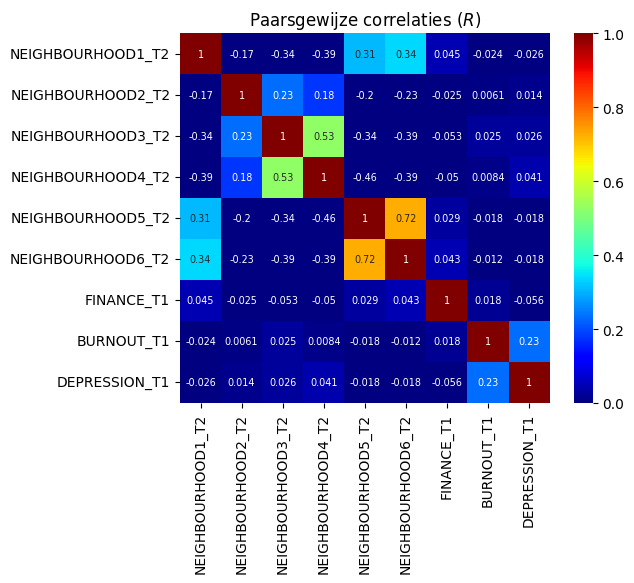

In [57]:
axs = sns.heatmap(lifelines_df[["NEIGHBOURHOOD1_T2", "NEIGHBOURHOOD2_T2", "NEIGHBOURHOOD3_T2", "NEIGHBOURHOOD4_T2", "NEIGHBOURHOOD5_T2","NEIGHBOURHOOD6_T2", "FINANCE_T1", "BURNOUT_T1", "DEPRESSION_T1"]].corr(), annot=True, annot_kws={"fontsize": "x-small"}, cmap="jet", vmin=0.0, vmax=1.0, square=True)
axs.set_title("Paarsgewijze correlaties ($R$)")

De bovenstaande heatmap laat geen hele sterke correlaties zien tussen de features die gebruikt worden. 
In het bijzonder "NSES" wat volgens de metadata van de dataset "Neighborhood socio-economic status score according to CBS" is.
Mijn verwachting was dat dit wel een bijdragende factor zou kunnen zijn aangezien rijke buurten rijke mensen aantrekken. 

## Machine learning:


In het onderstaande code blok worden de features die gebruikt moeten worden geselecteerd.
Daarna wordt er een split gemaakt van test/train data. 

<hr>

Het volgende model moet "NEIGHBOURHOOD6_T2" voorspellen. Dit is de mate waarin mensen zich thuisvoelen in de buurt waar ze wonen. <br>

Er is 




**De beschrijving van van deze features:**

```

NEIGHBOURHOOD1_T2 'Satisfaction with the current living environment (scored on a scale of 1 to 10) at second assessment (T2)'

NEIGHBOURHOOD2_T2 'Characteristics of neighbourhood (ranging from a very green neighbourhood (1) to a neighbourhood with practically no greenery (5)) at second assessment (T2)'

NEIGHBOURHOOD3_T2 'Unpleasantness to live in this neighbourhood (ranging from completely disagree (1) tot completely agree (5)) at second assessment (T2)'

NEIGHBOURHOOD4_T2 'If possible, would like to move from this neighbourhood (ranging from completely disagree (1) tot completely agree (5)) at second assessment (T2)'

NEIGHBOURHOOD5_T2 'Attached to this neighbourhood (ranging from completely disagree (1) tot completely agree (5)) at second assessment (T2)'

NEIGHBOURHOOD6_T2 'Feels at home in this neighbourhood (ranging from completely disagree (1) tot completely agree (5)) at second assessment (T2)'

```


De volgende features zijn geselecteerd om 

In [271]:

ordinal_columns = ["NEIGHBOURHOOD1_T2", "NEIGHBOURHOOD2_T2", "NEIGHBOURHOOD3_T2", "NEIGHBOURHOOD4_T2", "NEIGHBOURHOOD5_T2", "FINANCE_T1"]
# categorical_columns = [] #To-do: misschien nog meer features toevoegen.
to_predict = ["NEIGHBOURHOOD6_T2"]


y_not_imputed = lifelines_df[to_predict]
X_not_imputed = lifelines_df[ordinal_columns]


In [272]:

# Split eerste alles voor imputatie:
X_train_not_imputed, X_test_not_imputed, y_train_not_imputed, y_test_not_imputed = train_test_split(X_not_imputed,y_not_imputed, train_size=0.8)


Er is nu een split gemaakt van 80% train data en 20% evaluatiedata. 

De "SimpleImputer" vervangt elke missende waarde met de categorie die het meeste voor komt. 


In [273]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

# Imputeer NA's:

feature_imputer = SimpleImputer(strategy='most_frequent')
feature_imputer.fit(X_train_not_imputed)

X_train_imputed = feature_imputer.transform(X_train_not_imputed)
X_test_imputed = feature_imputer.transform(X_test_not_imputed)


target_imputer = SimpleImputer(strategy='most_frequent')
y_train = target_imputer.fit_transform(y_train_not_imputed.values.reshape(-1, 1)).ravel()
y_test = target_imputer.transform(y_test_not_imputed.values.reshape(-1, 1)).ravel()

De ordinale features worden vervolgens met de "OrdinalEncoder()" ge-onehotencode.

In [274]:
encoder = OrdinalEncoder()
encoder.fit(X_train_imputed)

X_train_onehot = encoder.transform(X_train_imputed)
X_test_onehot = encoder.transform(X_test_imputed)

De klassen zijn niet gebalanceerd. Hieronder wordt gebruik gemaakt van SMOTE voor oversampling. 

In [275]:

print(f"Verdeling voor SMOTE: \n {pd.Series(y_train).value_counts()} \n")

# De "Auto" sampling strategy werkte niet. 
smote = SMOTE(sampling_strategy={
    1.0: 800,   
    2.0: 1200,   
    3.0: 2500,
    5.0: 5000  
}, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_onehot, y_train)

print(f"Verdeling na SMOTE: \n {pd.Series(y_train_smote).value_counts()}")


Verdeling voor SMOTE: 
 4.0    9198
5.0    2682
3.0    1036
2.0     279
1.0     161
Name: count, dtype: int64 

Verdeling na SMOTE: 
 4.0    9198
5.0    5000
3.0    2500
2.0    1200
1.0     800
Name: count, dtype: int64


Test: grid search

In [276]:
#restClassifier().fit(X_train_onehot, y_train)

# from sklearn.grid_search import GridSearchCV
# model = RandomForestClassifier(random_state=30)
# param_grid = { "n_estimators"      : [250, 300],
#            "criterion"         : ["gini", "entropy"],
#            "max_features"      : [3, 5],
#            "max_depth"         : [10, 20],
#            "min_samples_split" : [2, 4] ,
#            "bootstrap": [True, False]}
# grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=2)
# grid_search.fit(X_train_onehot, y_train)
# print(grid_search.best_params_)


# y_pred = model.predict(X_test_onehot)


# accuracy_score(y_test, y_pred)


De bovenstaande code gaf voor het omzetten van y_train en y_test een waarschuwing bij het fitten van het model dat het een 1D array moet zijn i.p.v. een kolom vector, daarom de ".reshape"

In [277]:

# X = np.nan_to_num(lifelines_df[["SMOKING", "AGE_T1", "WORK_T1", "HEIGHT_T1", "WEIGHT_T1", "GENDER", "LOW_QUALITY_OF_LIFE_T1"]].to_numpy())
# y = np.nan_to_num(lifelines_df["SMOKING"].to_numpy())

# ["NEIGHBOURHOOD1_T2", "NEIGHBOURHOOD2_T2", "NEIGHBOURHOOD3_T2", "NEIGHBOURHOOD4_T2", "NEIGHBOURHOOD5_T2", "NEIGHBOURHOOD6_T2"]
#y = lifelines_df["LOW_QUALITY_OF_LIFE_T2"].to_numpy()



#X.shape, X.dtype, y.shape, y.dtype

Aan de hand van de datapunten bescheven bij X, voorspeld wordt of mensen gelukkig zijn of niet (LOW_QUALITY_OF_LIFE_T1)
In het metadata bestand dat bij deze dataset hoort betekekend dat de ondervraagde mensen hun leven als "poor/mediocre" bechreven. 

To-do: andere features selecteren voor X.


In [278]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC


models = [
    DummyClassifier,
    DecisionTreeClassifier,
    GaussianNB,
    KNeighborsClassifier,
    RandomForestClassifier,
    LinearDiscriminantAnalysis,
    AdaBoostClassifier,
    MLPClassifier#,
    #SVC,
    
  #  GaussianProcessClassifier # Duurt lang om uit te voeren...
]

# Maak dict met scores voor elk model:
score_dict = {}

for model in models:
    model_name = model()
    model_name.fit(X_train_smote, y_train_smote)
    score_dict[model_name] = model_name.score(X_test_onehot, y_test)
    


/tmp/ipykernel_890170/1258411724.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="Score", data=model_scores, palette="Greens")


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'DummyClassifier()'),
  Text(1, 0, 'GaussianNB()'),
  Text(2, 0, 'AdaBoostClassifier()'),
  Text(3, 0, 'KNeighborsClassifier()'),
  Text(4, 0, 'MLPClassifier()'),
  Text(5, 0, 'LinearDiscriminantAnalysis()'),
  Text(6, 0, 'DecisionTreeClassifier()'),
  Text(7, 0, 'RandomForestClassifier()')])

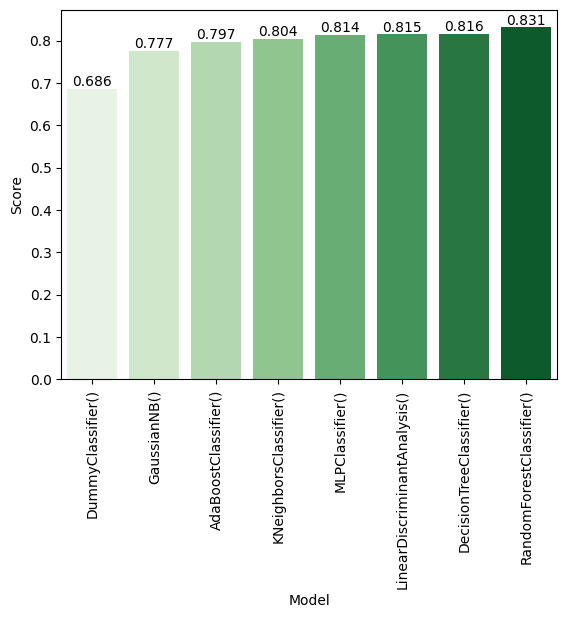

In [279]:
model_scores = pd.DataFrame(list(score_dict.items()), columns=["Model", "Score"])
model_scores = model_scores.sort_values(by=["Score"],ascending=True)

ax = sns.barplot(x="Model", y="Score", data=model_scores, palette="Greens")

for i in ax.containers:
    ax.bar_label(i,fmt="%.3f") # Voeg labels toe, rond af op 3 decimalen.

plt.xticks(rotation=90)

Het beste model:

In [280]:
top_model = model_scores.iloc[-1]["Model"]

print(f"Het beste model is: {top_model}")

Het beste model is: RandomForestClassifier()


In [281]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_validate

metric_scores = {}
k = 6

while k:
    X_select = SelectKBest(k=k).fit_transform(X_train_smote, y_train_smote)
    scores = cross_validate(RandomForestClassifier(), X_select, y_train_smote, cv=5, return_train_score=True)
    for key, value in scores.items():
        scores[key] = value.mean()
    metric_scores[f"{k} features"] = scores
    k -= 1

(pd.DataFrame(metric_scores).T).head()


,fit_time,score_time,test_score,train_score
6 features,0.674794,0.041010,0.838597,0.916756
5 features,0.562404,0.033139,0.819343,0.880669
4 features,0.500130,0.027518,0.809983,0.862860
3 features,0.326629,0.020765,0.785434,0.834354
2 features,0.295089,0.017856,0.762864,0.807680


Eerst heb ik bepaald wat het optimale aantal features is. De hoogste score was verkregen wanneer alle 6 features gebruikt werden.  <br>
Daarna wat de optimale max_depth van de tree is. 
<br>
Het limiet van max_depth was eerst 10 maar aangezien dat de hooste test_score kreeg heb ik hem verhoogd naar 50. Het duurt nu wel aanzienlijk langer om uit te voeren. 
De optimale max_depth lag toen bij 25.

In [282]:
metric_scores = {}
max_depth = 1
max_depth_limit = 25

while max_depth <= max_depth_limit:
    clf = RandomForestClassifier(max_depth=max_depth)
    scores = cross_validate(clf, X_train_smote, y_train_smote, cv=5, return_train_score=True)
    
    # Average the scores
    for key, val in scores.items():
        scores[key] = val.mean()
    
    metric_scores[f"max_depth={max_depth}"] = scores
    max_depth += 1

pd.DataFrame(metric_scores).T

,fit_time,score_time,test_score,train_score
max_depth=1,0.183267,0.008364,0.681463,0.681530
max_depth=2,0.221152,0.010603,0.722645,0.724168
max_depth=3,0.264873,0.013476,0.733662,0.733835
max_depth=4,0.296621,0.013924,0.750776,0.751270
max_depth=5,0.328682,0.015234,0.768747,0.772302
max_depth=6,0.360336,0.017119,0.780459,0.788293
max_depth=7,0.388642,0.018361,0.796451,0.808736
max_depth=8,0.420803,0.020457,0.807041,0.826038
max_depth=9,0.447502,0.022583,0.815277,0.841721
max_depth=10,0.474139,0.024817,0.824370,0.857365


Deze features worden nu weergeven op volgorde van meest informatief tot het minst informatief.
Hier wordt de "ordinal_columns" lijst voor gebruikt met alle gebruikte features.

In [283]:
selector = SelectKBest(k=7).fit(X_train_smote, y_train_smote)

pd.DataFrame({"Attribute": ordinal_columns, "Score": selector.scores_}).sort_values("Score", ascending=False).set_index("Attribute")

/home/floris/Documenten/git_repo/Lifelines_Classifier/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=7 is greater than n_features=6. All the features will be returned.
  warnings.warn(


,Score
Attribute,
NEIGHBOURHOOD5_T2,9566.126839
NEIGHBOURHOOD4_T2,1674.363770
NEIGHBOURHOOD3_T2,1630.896230
NEIGHBOURHOOD1_T2,905.915231
NEIGHBOURHOOD2_T2,516.428712
FINANCE_T1,22.164898


De "Finance" kolom lijkt amper bij te dragen. Deze kolom beschrijft het inkomen van de deelnemer en is verdeeld in een aantal categorien.   <br>
Volgens de metadata:
```
*FINANCE_T1 - categories:
1 = ‘I do not know’
2 = ‘I would rather not answer this question’
3 = Less than 750
4 = 750 - 1000
5 = 1000 - 1500
6 = 1500 - 2000
7 = 2000 - 2500
8 = 2500 - 3000
9 = 3000 - 3500
10 = More than 3500

```
De belangrijkste feature is "NEIGHBOURHOOD5_T2" wat een score is van hoe erg mensen gehecht zijn aan de buurt waarin ze wonen. 

Voor automatische model selectie (op basis van de hoogste score) maakt de onderstaande code gebruik van top_model.fit() <br>
Maar aangezien het beste model Randomforest was en we hierboven de beste hyperparameters vastgesteld hebben, maken we geen gebruik van "top_model". 

In [284]:
# Cross-validatie
from sklearn.model_selection import cross_validate

metric_scores = {}
for model in models:
    scores = cross_validate(model(), X_train_smote, y_train_smote,cv=5, return_train_score=True)
    for key, val in scores.items():
        scores[key] = val.mean()
    metric_scores[f"{model.__name__}"] = scores
    
pd.DataFrame(metric_scores).T

/home/floris/Documenten/git_repo/Lifelines_Classifier/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/floris/Documenten/git_repo/Lifelines_Classifier/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/floris/Documenten/git_repo/Lifelines_Classifier/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/floris/Documenten/git_repo/Lifelines_Classifier/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

,fit_time,score_time,test_score,train_score
DummyClassifier,0.000734,0.000513,0.491924,0.491924
DecisionTreeClassifier,0.019290,0.001316,0.816080,0.916769
GaussianNB,0.003271,0.001617,0.732486,0.733394
KNeighborsClassifier,0.008287,0.170891,0.815598,0.853541
RandomForestClassifier,0.628825,0.039871,0.839346,0.916769
LinearDiscriminantAnalysis,0.004311,0.000707,0.738422,0.738140
AdaBoostClassifier,0.185948,0.012365,0.764201,0.768491
MLPClassifier,5.213445,0.001983,0.788428,0.797438


In [285]:
# from sklearn.feature_selection import SelectKBest
#selector = SelectKBest(k=7).fit(X_train_smote, y_train_smote)

#pd.DataFrame({"Attribute": codebook["attribute"], "Score": selector.scores_}).sort_values("Score", ascending=False).set_index("Attribute")

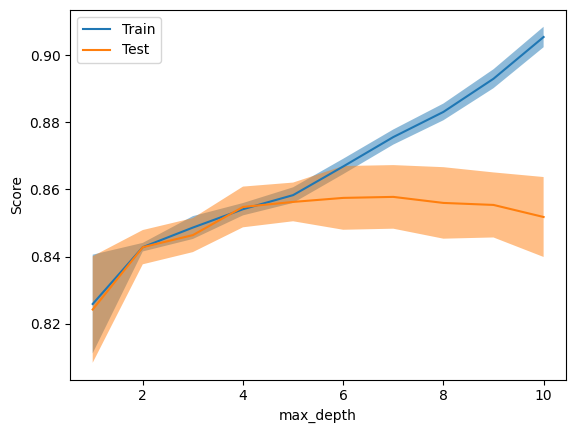

In [286]:
from sklearn.utils import shuffle
from sklearn.model_selection import ValidationCurveDisplay, validation_curve

X_randomforest_validation_curve, y_randomforest_validation_curve = shuffle(X_test_onehot, y_test, random_state=0)
ValidationCurveDisplay.from_estimator(
    RandomForestClassifier(), X_randomforest_validation_curve, y_randomforest_validation_curve, 
    param_name="max_depth", param_range=np.array([1,2,3, 4, 5, 6, 7, 8, 9 ,10])
)

Volgens de bovenstaande grafiek is het Randomforest model het best bij een max_depth van ongeveer 7.

## Model trainen met optimale hyperparameters:

Fit het model op beide de oversampled en niet oversampled trainingsdata.

In [287]:
from sklearn.metrics import multilabel_confusion_matrix

#model = top_model.fit(X_train_smote, y_train_smote)

# Met SMOTE:
model = RandomForestClassifier(max_features=6, max_depth=25).fit(X_train_smote, y_train_smote)

# Zonder SMOTE:
model_without_smote = RandomForestClassifier(max_features=6, max_depth=25).fit(X_train_onehot, y_train)


Gebruik de test data om de nieuwe voorspellingen te maken:

In [288]:
y_pred_smote = model.predict(X_test_onehot)

y_pred_without_smote = model_without_smote.predict(X_test_onehot)

## Evaluatie:

De accuracy berekenen. 

In [289]:
from sklearn.metrics import confusion_matrix, accuracy_score, RocCurveDisplay

acc_smote = accuracy_score(y_test, y_pred_smote)
acc_without_smote = accuracy_score(y_test, y_pred_without_smote)

print(f"De accuracy is {acc_smote} met SMOTE.")

print(f"De accuracy is {acc_without_smote} zonder SMOTE.")


De accuracy is 0.8266467065868264 met SMOTE.
De accuracy is 0.8446107784431137 zonder SMOTE.


Het model is accurater zonder SMOTE.... <br>
De gebruikte oversampling methode is: auto


## Confusion matrix

De feature die voorspeld moet worden heeft 5 klassen, volgens de metadata "ranging from completely disagree (1) tot completely agree (5)" <br>
Dit slaat op de vraag of de deelnemer zich thuis voelt in zijn/haar woonomgeving. 

Met SMOTE:

<Axes: >

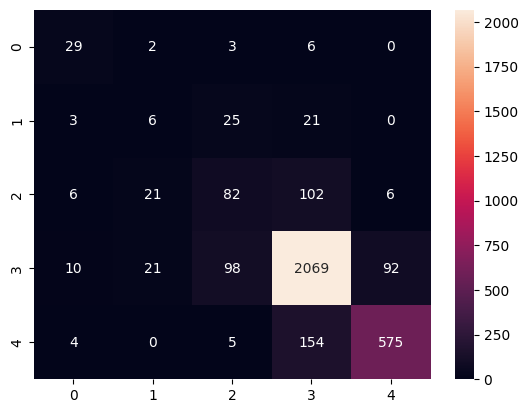

In [314]:
sns.heatmap(confusion_matrix(y_test, y_pred_smote), fmt='d', annot=True)

Zonder SMOTE:

<Axes: >

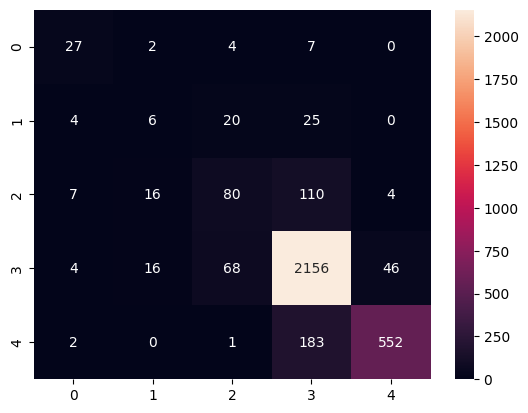

In [313]:
sns.heatmap(confusion_matrix(y_test, y_pred_without_smote), fmt='d', annot=True)

De versie zonder oversampling presteerd hier beter voor alle klassen met uitzondering van 5. 

De klassen beginnen hier bij 0 maar ik tel ze vanaf 1 omdat ze ook vergeleken worden met andere grafieken die bij 1 beginnen...

Het model is niet goed in het classificeren van klasse 1. Er waren maar 201 "echte" waarden voor deze klasse. (zie onderstaande grafiek) Dit is wel aangevuld met smote maar dat was niet voldoende om het model goed te laten presteren. 

Voor de andere klassen voorspeld het model wel steeds het meest frequent de juiste klasse. Al is klasse 0 vaak aangezien voor 2.

Het model is het best in het voorspellen van de positive scores, wanneer een 3 of 4 gegeven is. 

**Ter herinnering: De verdeling van deze data:**


<Axes: xlabel='NEIGHBOURHOOD6_T2', ylabel='count'>

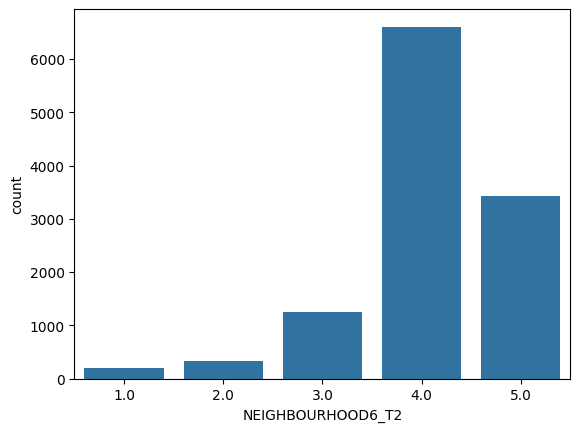

In [292]:
sns.countplot(lifelines_df, x="NEIGHBOURHOOD6_T2")

De verdeling van de data is waarschijnlijk de reden waarom het model beter is in het classificeren van klasse 3 en 4. (Of 4 en 5 wanneer er vanaf 1 geteld wordt) <br>
De overweldigende meerderheid behoorde tot klasse 4.

In de volgende code wordt een vergelijking gemaakt tussen de ROC curves voor het model dat getrained is met SMOTE oversampling vs zonder oversampling. <br>

Omdat er meerdere klassen zijn is er voor elke klasse een grafiek. <br>



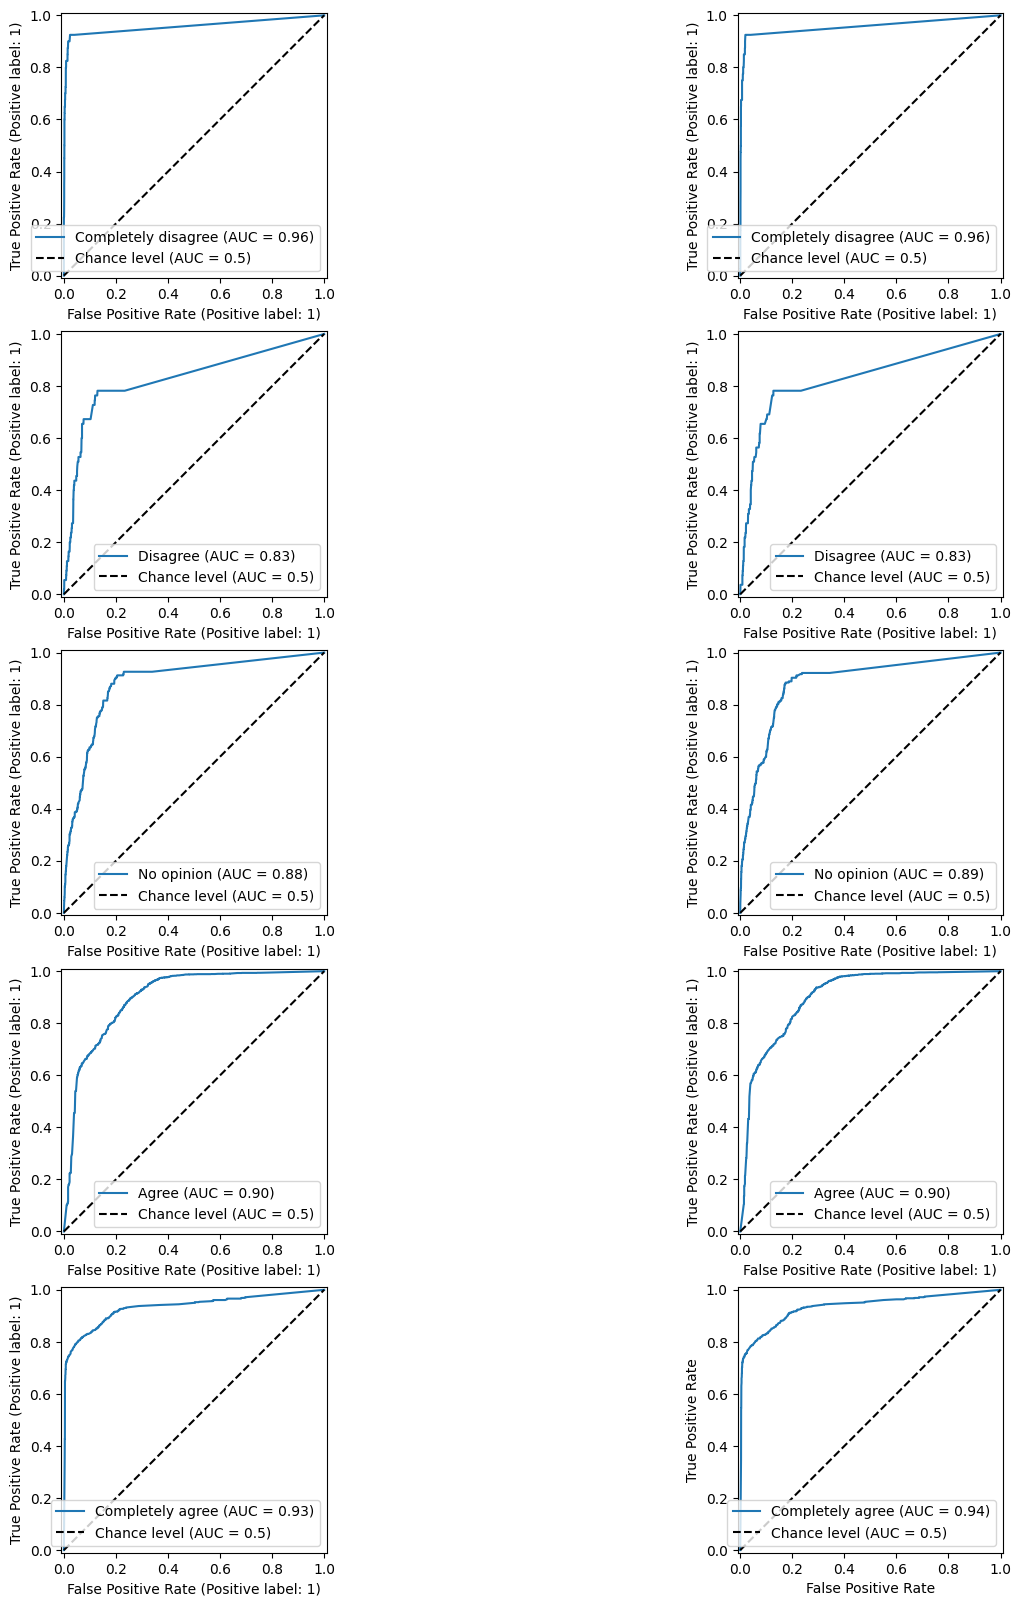

In [304]:
y_pred_probability = model.predict_proba(X_test_onehot)
y_pred_probability_no_smote = model_without_smote.predict_proba(X_test_onehot)

class_names = {
    1.0: "Completely disagree",
    2.0: "Disagree",
    3.0: "No opinion", 
    4.0: "Agree",
    5.0: "Completely agree"
}

classes = np.unique(y_train)

fig, axes = plt.subplots(5, 2, figsize=(16, 20))

for i, class_id in enumerate(range(len(classes))):
    y_test_binary = (y_test == classes[i]).astype(int)
    class_name = class_names.get(classes[i], f"Class {classes[i]}")
    
    # Met SMOTE:
    RocCurveDisplay.from_predictions(
        y_test_binary,
        y_pred_probability[:, i],
        name=class_name,
        ax=axes[i, 0],
        plot_chance_level=True, 
    )

    # Zonder SMOTE:
    RocCurveDisplay.from_predictions(
        y_test_binary,
        y_pred_probability_no_smote[:, i],
        name=class_name,
        ax=axes[i, 1],
        plot_chance_level=True, 
    )

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



De bovenstaande figuren weergeven de ROC curve voor elk van de klassen. <br>
Niet elke klasse komt even veel voor, dat is waarom de curve van 1 t/m 3 een minder "vloeiende" lijn hebben. 

Op het oog lijken veel van de SMOTE / geen SMOTE grafieken op elkaar. De AUC verschilde ook weinig. 


#### Invloed van SMOTE:
Heeft oversampling geholpen? Niet veel.

Ik heb de sample strategie aangepast van auto naar een zelf verzonnen ratio, dit presteerde beter maar nog steeds bijna het zelfde.  <br>
Deze ratio was los gebaseerd op de verdeling van de echte waarden, meer oversampling voor de datapunten waar al veel van waren en minder voor die waar er weinig van zijn. 

(bron: https://imbalanced-learn.org/stable/auto_examples/api/plot_sampling_strategy_usage.html)

## Conclusie / Discussie

Het resulterende model van deze bovestaande stappen presteerd matig. <br>
Voor de ondergerepresenteerde klassen zijn de voorspellingen niet goed. <br>
Het kan zijn dat de correlatie tussen of mensen zich thuis voelen in hun buurt en de andere karakteristieken van hun buurt. Dit gaat tegen mijn verwachting in.<br>
Een andere, meer waarschijlijke optie is dat er niet genoeg datapunten waren voor de klasses die slechter voorspeld worden dan de anderen. 
Dit lijkt ook overeen te komen met de verdeling van de data, wanneer er veel 


In [295]:
## Test met pipeline:
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.datasets import make_blobs
# from sklearn import set_config

# X, y = make_blobs(n_samples=500, centers=9, n_features=20,

#                   random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# classifiers = [
#     DummyClassifier(),
#     KNeighborsClassifier(),
#     DecisionTreeClassifier(),
#     GaussianNB(),
#     KNeighborsClassifier(),
#     RandomForestClassifier(),
#     LinearDiscriminantAnalysis(),
#     AdaBoostClassifier(),
#     MLPClassifier(),
#     SVC(),
    
#     ]

# param_grid = {
#     "pca__n_components": [5, 15, 30, 45, 60],
#     "logistic__C": np.logspace(-4, 4, 4),
# }

# evaluation = {}
# cross_validation_results = {}

# for classifier in classifiers:
#     pipeline = Pipeline(steps=[
#         ("scaler", StandardScaler()),
#         ('classifier', classifier)
#     ])

#     cross_validate(pipeline, X_train, y_train)

#     cross_validation_results[classifier] = {"Train score:": scores["train_score"]}

#     test = GridSearchCV(pipeline, param_grid, n_jobs=2)
#     evaluation[classifier] = pipeline.fit(X_train, y_train).score(X_test, y_test)

# print(cross_validation_results)
# set_config(display="diagram")
# pipeline

# #pipeline.set_params(svc__C=10).fit(X_train, y_train).score(X_test, y_test)


In [296]:
model_scores = pd.DataFrame(list(evaluation.items()), columns=["Model", "Score"])
model_scores = model_scores.sort_values(by=["Score"],ascending=True)

ax = sns.barplot(x="Model", y="Score", data=model_scores, palette="Greens")

for i in ax.containers:
    ax.bar_label(i,fmt="%.3f") # Voeg labels toe, rond af op 3 decimalen.

plt.xticks(rotation=90)

NameError: name 'evaluation' is not defined

To-do:
NA's verwijderen
Confusion matrix maken en interpreteren
Introductie schrijven
Uitleg dataset geven 
Uitleg voor alle stappen geven
